In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

In [4]:
path_train = "trainingData.csv"
path_validation = "validationData.csv"

In [27]:

def get_data_files():
    train_files = []
    test_files = []
    import os
    dir = sourceFolder
    dbtype_list = os.listdir(dir)
    for dbtype in dbtype_list:
        if dbtype.find("train")!= -1:
            train_files.append(sourceFolder+dbtype)
        elif dbtype.find("test")!= -1:
            test_files.append(sourceFolder+dbtype)
    train_files =sorted(train_files,key=str.lower)
    test_files =sorted(test_files,key=str.lower)
    return train_files, test_files

#train_files,test_files = get_data_files()
#print(train_files)
#print(test_files)
def load_train_test_data(file):
    train_df = pd.read_csv(file, header=0)
    fp = train_df.iloc[:,1:-3]
    loc = train_df.iloc[:,[-3,-2]]
    ap_num = fp.columns.size
    return fp,loc,ap_num
def load_test_data(file):
    test_df = pd.read_csv(file,header = 0)
    fps = test_df.iloc[:,1:-1]
    fp_size = fps.columns.size
    fps = (np.asarray(fps))/200 + 0.5
    where_are_nan = np.isnan(fps)
    fps[where_are_nan] = 1
    site_path_ts = test_df.iloc[:,-1]
    return fps,fp_size,site_path_ts
def train_val_split(train_AP_features,train_labels):
    #generate len(train_AP_features) of floats in between 0 and 1
    train_val_split = np.random.rand(len(train_AP_features))
    #convert train_val_split to an array of booleans: if elem < 0.7 = true, else: false
    train_val_split = train_val_split < 1 #should contain ~70% percent true
    # We will then split our given training set into training + validation 
    train_X = train_AP_features[train_val_split]
    train_y = train_labels[train_val_split]
    val_X = train_AP_features[~train_val_split]
    val_y = train_labels[~train_val_split]
    return train_X,train_y, val_X, val_y
def normalization(data):
    minVals = data.min(0)
    maxVals = data.max(0)
    ranges = maxVals - minVals
    normData = (data - minVals)/ranges
    return normData,ranges,minVals

def load_train_data(file_name):
    fps,loc,ap_num = load_train_test_data(file_name)
    fps = (np.asarray(fps))/200 + 0.5
    where_are_nan = np.isnan(fps)
    fps[where_are_nan] = 1
    labels = np.asarray(loc) #labels is an array of shape 19937 x 13. (there are 13 types of labels)
    labels,ranges,minVals =  normalization(labels)
    train_X,train_y, val_X, val_y =  train_val_split(fps, labels)
    return train_X,train_y, val_X, val_y,ranges,ap_num,minVals

def dec2bin(x,digits):
    digits_total = digits 
    bins = []
    if x>=1:
        x = 0.99999999
    x -= int(x)
    
    while x > 0 and digits > 0:
        x *= 2
        bins.append(1 if x>=1. else 0)
        x -= int(x)
        digits -= 1
    while len(bins) < digits_total:
        bins.append(0)
    return bins
def get_bin_digits(num):
    digits = 0
    while num >= 1:
        num/= 2
        digits+=1
    return digits
def get_code(point,digit):
    x = dec2bin(point[0],digit[0])
    y = dec2bin(point[1],digit[1])
    code_word = x+y
    return code_word

def bin2dec(bins):
    dec = 0
    frac = 1/2
    for bin in bins:
        dec += (bin) * frac
        frac *= 1/2
    return dec
def code_to_point(codes,digit):
    assert len(codes) == digit[0] + digit[1]
    x = bin2dec(codes[0:digit[0]])
    y = bin2dec(codes[digit[0]:])
    return (x,y)
def get_bin_digits(num):
    digits = 0
    while num >= 1:
        num/= 2
        digits+=1
    return digits
def get_code(point,digit):
    x = dec2bin(point[0],digit[0])
    y = dec2bin(point[1],digit[1])
    code_word = x+y
    return code_word

def bin2dec(bins):
    dec = 0
    frac = 1/2
    for bin in bins:
        dec += (bin) * frac
        frac *= 1/2
    return dec
def code_to_point(codes,digit):
    assert len(codes) == digit[0] + digit[1]
    x = bin2dec(codes[0:digit[0]])
    y = bin2dec(codes[digit[0]:])
    return (x,y)
from keras.optimizers import Adam,sgd
def hirarchical_structure_loss(y_true,y_pred):
    xent_loss = losses.binary_crossentropy(y_true, y_pred)
    #print(xent_loss)
    print(y_true.shape)
    weights = [1 for i in range(sum(digit))]
    print(weights)
    weights= K.constant(weights)
    cost = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, weights)
    return xent_loss

def weighted_hirarchical_structure_loss(digit,beta=0):
    def weighted_hirarchical_structure(y_true,y_pred):
        xent_loss = losses.binary_crossentropy(y_true, y_pred)
        #print(xent_loss)
        weights = [1-beta*(i%(sum(digit)/2)) for i in range(sum(digit))]
        bce = tf.keras.losses.BinaryCrossentropy()
        return bce(y_true, y_pred, sample_weight=weights)
    return weighted_hirarchical_structure
def mean_squared_error_index(ranges = [1,1]):
    def mean_squared_error_ind(y_true, y_pred):
        return K.mean(K.square(y_pred*ranges - y_true*ranges), axis=-1)
    return mean_squared_error_ind

def mean_squared_error_index_out(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def cross_loss(appended_ranges,beta=0):
    def cross_structure(y_true,y_pred):
        y_true_part1 = y_true[:,0:18]
        y_true_part2 = y_true[:,18:]
        y_pred_part1 = y_pred[:,0:18]
        y_pred_part2 = y_pred[:,18:]
        loss1 = losses.binary_crossentropy(y_true_part1, y_pred_part1)
        loss2 = losses.mse(y_true_part2,y_pred_part2)
        #print(xent_loss)
        #weights = [1 for i in range(18)]
        #weights.append(0)
        #weights.append(0)
        #print(weights)
        #weight_2 = [0 for i in range(18)]
        #weight_2.append(0)
        #weight_2.append(0)
        #bce = tf.keras.losses.BinaryCrossentropy()
        #loss1 = bce(y_true, y_pred, sample_weight=weights)
        #loss2 = mean_squared_error_index_out(y_true* weight_2*appended_ranges/100, y_pred* weight_2*appended_ranges/100)
        return loss1+10*loss2
    return cross_structure
    
def cross_hierarchical_soft_max(appended_ranges):
    model = Sequential()
    model.add(Dense(1024, input_dim=input_size, activation='relu', bias=True))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu', bias=True))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', bias=True))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', bias=True))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='tanh', bias=True))
    model.add(Dense((sum(digit)+2), activation='sigmoid', bias=True))
    #print(sum(digit))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=[cross_loss(appended_ranges)],metrics=[cross_loss(appended_ranges)])
    return model
    
def hirarchical_softmax(digit,beta=0):
    model = Sequential()
    model.add(Dense(512, input_dim=input_size, activation='relu', bias=True))
    model.add(Dense(512, activation='relu', bias=True))
    
    model.add(Dense(128, activation='relu', bias=True))
    model.add(Dense(128, activation='relu', bias=True))
    model.add(Dense(32, activation='relu', bias=True))
    output_num = sum(digit) + 2
    print(output_num)
    model.add(Dense(output_num, activation='sigmoid', bias=True))
    #print(sum(digit))
    model.compile(optimizer=sgd(learning_rate=0.01), loss=[weighted_hirarchical_structure_loss(digit,beta=beta)],metrics=['accuracy'])
    return model


def mlp_regression():
    model1 = Sequential()
    model1.add(Dense(1024, input_dim=input_size, activation='relu', bias=True))
    model1.add(Dense(512, activation='relu', bias=True))
    model1.add(Dense(128, activation='relu', bias=True))
    model1.add(Dense(128, activation='relu', bias=True))
    model1.add(Dense(32, activation='relu', bias=True))
    model1.add(Dense(2, activation='sigmoid', bias=True))
    #model1.compile(optimizer='sgd', loss=[mean_squared_error_index],metrics=[mean_squared_error_index])
    return model1    

def code2pos_batch(codes,digit,ranges,bias):
    points = [] 
    for code in codes:
        points.append(code_to_point(pred,digit))
    return points * ranges + bias

def mean_squared_error(y_true, y_pred):
    return math.sqrt((y_true[0]-y_pred[0])**2+(y_true[1]-y_pred[1])**2)

def cdf(data):
    hist, bin_edges = np.histogram(data,bins=100)
    cdf = np.cumsum(hist/sum(hist))
    return bin_edges[1:],cdf
def rms(list):
    sum = 0
    for term in list:
        sum+= term*term
    rms = math.sqrt(sum / len(list))
    return rms


In [28]:
#Explicitly pass header=0 to be able to replace existing names 
train_df = pd.read_csv(path_train,header = 0)
train_df = train_df[:19930]
print(train_df.head(2))
train_AP_strengths =train_df.loc[:,'WAP001':'WAP520']
train_AP_features = (np.asarray(train_AP_strengths))/200 + 0.5
#The following two objects are actually pandas.core.series.Series objects
building_ids_str = train_df["BUILDINGID"].map(str) #convert all the building ids to strings
building_floors_str = train_df["FLOOR"].map(str) #convert all the building floors to strings

res = building_ids_str + building_floors_str #element wise concatenation of BUILDINGID+FLOOR
train_labels = np.asarray(building_ids_str + building_floors_str)

#convert labels to categorical variables, dummy_labels has type 'pandas.core.frame.DataFrame'
dummy_labels = pd.get_dummies(train_labels)

"""one hot encode the dummy_labels.
this is done because dummy_labels is a dataframe with the labels (BUILDINGID+FLOOR) 
as the column names
"""
train_labels = np.asarray(dummy_labels) #labels is an array of shape 19937 x 13. (there are 13 types of labels)
train_X,train_y, val_X, val_y = train_val_split(train_AP_features,train_labels)

#Turn the given validation set into a testing set
test_df = pd.read_csv(path_validation,header = 0)
test_AP_features = (np.asarray(test_df.loc[:,'WAP001':'WAP520']))/200+0.5
test_labels = np.asarray(test_df["BUILDINGID"].map(str) + test_df["FLOOR"].map(str))
test_labels = np.asarray(pd.get_dummies(test_labels))
input_size = 520

   WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   

   WAP010  ...  WAP520  LONGITUDE      LATITUDE  FLOOR  BUILDINGID  SPACEID  \
0     100  ...     100 -7541.2643  4.864921e+06      2           1      106   
1     100  ...     100 -7536.6212  4.864934e+06      2           1      106   

   RELATIVEPOSITION  USERID  PHONEID   TIMESTAMP  
0                 2       2       23  1371713733  
1                 2       2       23  1371713691  

[2 rows x 529 columns]


In [7]:
#cross_model = cross_hierarchical_soft_max(appended_ranges)
hi = hirarchical_softmax(digit,0)
hi.summary()
print(train_y)
print(train_code_y)
print(sum(digit))
#print(cross_train_code_y.shape)
#print(train_code_y)
#train_code_y = np.reshape(19563,18)
batch_size = 64
#print(appended_ranges)
hi.fit(train_X,train_code_y,nb_epoch=200,batch_size=batch_size)

NameError: name 'digit' is not defined

[390.51940991 270.94278403]
[390.51940991 270.94278403]
19937
19937


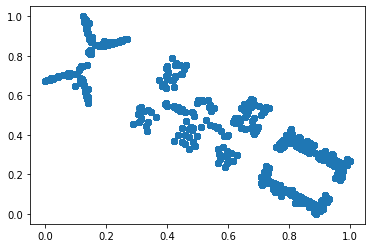

example point:  [0.38429357 0.6460153 ]
example code [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0]
convert code back to pos: (0.3828125, 0.64453125)
[[0.         1.         1.         ... 0.         0.38429357 0.6460153 ]
 [0.         1.         1.         ... 0.         0.39618312 0.69564571]
 [0.         1.         1.         ... 1.         0.44091534 0.75214103]
 ...
 [0.         1.         1.         ... 1.         0.44683285 0.52980183]
 [0.         1.         1.         ... 1.         0.39438885 0.55373567]
 [0.         1.         1.         ... 1.         0.39734926 0.56142549]]
[[0. 1. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 1. 0. 0.]
 [0. 1. 1. ... 0. 0. 1.]
 ...
 [0. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 0. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]]
check training feature's shape:  (19937, 20)
check training feature's shape:  (19937, 18)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:176: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, input_dim=520, activation="relu", use_bias=True)`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", use_bias=True)`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:180: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", use_bias=True)`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:182: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", use_bias=True)`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:184: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="tanh", use_bias=True)`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1024)              533504    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1000
19937/19937 [==============================] - 6s 306us/step - loss: 1.0570 - cross_structure: 1.0570
Epoch 2/1000
19937/19937 [==============================] - 5s 273us/step - loss: 0.7524 - cross_structure: 0.7524
Epoch 3/1000
19937/19937 [==============================] - 6s 280us/step - loss: 0.7123 - cross_structure: 0.7123
Epoch 4/1000
19937/19937 [==============================] - 6s 276us/step - loss: 0.6890 - cross_structure: 0.6890
Epoch 5/1000
19937/19937 [==============================] - 5s 275us/step - loss: 0.6745 - cross_structure: 0.6745
Epoch 6/1000
19937/19937 [==============================] - 6s 278us/step - loss: 0.6663 - cross_structure: 0.6663
Epoch 7/1000
19937/19937 [==============================] - 6s 277us/step - loss: 0.6577 - cross_structure: 0.6577
Epoch 8/1000
19937/19937 [==============================] - 6s 279us/step - loss: 0.6519 - cross_structure: 0.6519
Epoch 9/1000
19937/19937 [==============================] - 6s 276us/step - loss

In [ ]:
longitude_scale = 0.00001141
latitude_scale = 0.00000899
def normalization(data):
    minVals = data.min(0)
    maxVals = data.max(0)
    ranges = maxVals - minVals
    normData = (data - minVals)/ranges
    return normData,ranges,minVals
from tensorflow.keras import metrics,losses
train_df = pd.read_csv(path_train,header = 0)
train_AP_strengths =train_df.loc[:,'WAP001':'WAP520']
train_AP_features = (np.asarray(train_AP_strengths))/200 + 0.5
train_df_LL = train_df.loc[:,'LONGITUDE':'LATITUDE']
train_labels = np.asarray(train_df_LL)
train_labels,ranges,train_bias =  normalization(train_labels)
print(ranges)
#convert labels to categorical variables, dummy_labels has type 'pandas.core.frame.DataFrame'
#dummy_labels = pd.get_dummies(train_labels)
appended_ranges = np.append([0 for i in range(18)],ranges)
"""one hot encode the dummy_labels.
this is done because dummy_labels is a dataframe with the labels (BUILDINGID+FLOOR) 
as the column names
"""
#train_labels = np.asarray(dummy_labels) #labels is an array of shape 19937 x 13. (there are 13 types of labels)
train_X,train_y, val_X, val_y = train_val_split(train_AP_features,train_labels)
print(ranges)
x = train_y[:,0]*ranges[0]
y = train_y[:,1]*ranges[1]
print(len(x))
print(len(y))
from matplotlib import pyplot as plt
px = [y[0] for y in train_y]
py = [y[1] for y in train_y]
plt.scatter(px,py)
plt.show()
grid_size = 1
digit_x = get_bin_digits(ranges[0]/grid_size)
digit_y = get_bin_digits(ranges[1]/grid_size)
digit = [digit_x, digit_y]
example_point = train_y[0]
print("example point: ",example_point)
code = get_code(example_point,digit)
print("example code",code)
point_back  = code_to_point(code,digit)
print("convert code back to pos:",point_back)
train_code_y = np.empty(shape=(0, sum(digit)))
cross_train_code_y = np.empty(shape=(0, sum(digit)+2))
for y in train_y:
    code = get_code(y,digit)
    cross_code = []
    #print(code)
    cross_code.extend(code)
    #print(cross_code)
    cross_code.extend(y)
    #print(cross_code)
    train_code_y = np.append(train_code_y,[code],axis=0)
    cross_train_code_y = np.append(cross_train_code_y,[cross_code],axis=0)
#print("finish coding all training labels, train_code_y: ",train_code_y[0])
print(cross_train_code_y)
print(train_code_y)
print("check training feature's shape: ", cross_train_code_y.shape)
print("check training feature's shape: ", train_code_y.shape)
#print("check testing feature's shape: ",test_code_y.shape)
#hirarchical_model = hirarchical_softmax(digit,beta=0)
batch_size = 50
#hirarchical_model.compile(optimizer=sgd(learning_rate=0.01), loss=[hirarchical_structure_loss],metrics=['binary_accuracy'])
#hirarchical_model.fit(train_X, train_code_y, nb_epoch=1000, batch_size=batch_size)
cross_model = cross_hierarchical_soft_max(appended_ranges)
cross_model.compile(optimizer=sgd(learning_rate=0.01), loss=[cross_loss(appended_ranges)],metrics=[cross_loss(appended_ranges)])
cross_model.summary()
cross_model.fit(train_X,cross_train_code_y,nb_epoch=1000,batch_size=batch_size)
#print("check testing feature's shape: ",test_code_y.shape)
#hirarchical_model = hirarchical_softmax(digit,0)
#batch_size = 50
#hirarchical_model.compile(optimizer=sgd(learning_rate=0.01), loss=[hirarchical_structure_loss],metrics=['binary_accuracy'])
#hirarchical_model.fit(train_X, cross_train_code_y, nb_epoch=50, batch_size=64)
#hirarchical_model.save('hiera_'+site_name+'.h5')

In [ ]:
hirarchical_model.compile(optimizer=sgd(learning_rate=0.01), loss=[hirarchical_structure_loss],metrics=['binary_accuracy'])
hirarchical_model.fit(train_X, train_code_y, nb_epoch=200, batch_size=64)

In [25]:
cross_model.fit(train_X,cross_train_code_y,nb_epoch=500,batch_size=batch_size)

Epoch 1/500
  650/19937 [..............................] - ETA: 5s - loss: 0.3280 - cross_structure: 0.3280

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


19937/19937 [==============================] - 6s 296us/step - loss: 0.3262 - cross_structure: 0.3262
Epoch 2/500
19937/19937 [==============================] - 6s 278us/step - loss: 0.3259 - cross_structure: 0.3259
Epoch 3/500
19937/19937 [==============================] - 6s 286us/step - loss: 0.3265 - cross_structure: 0.3265
Epoch 4/500
19937/19937 [==============================] - 6s 282us/step - loss: 0.3260 - cross_structure: 0.3260
Epoch 5/500
19937/19937 [==============================] - 6s 280us/step - loss: 0.3250 - cross_structure: 0.3250
Epoch 6/500
19937/19937 [==============================] - 6s 284us/step - loss: 0.3253 - cross_structure: 0.3253
Epoch 7/500
19937/19937 [==============================] - 6s 283us/step - loss: 0.3256 - cross_structure: 0.3256
Epoch 8/500
19937/19937 [==============================] - 6s 285us/step - loss: 0.3243 - cross_structure: 0.3243
Epoch 9/500
19937/19937 [==============================] - 6s 284us/step - loss: 0.3255 - cross_stru

Epoch 143/500
19937/19937 [==============================] - 6s 297us/step - loss: 0.3076 - cross_structure: 0.3076
Epoch 144/500
19937/19937 [==============================] - 6s 299us/step - loss: 0.3082 - cross_structure: 0.3082
Epoch 145/500
19937/19937 [==============================] - 6s 301us/step - loss: 0.3078 - cross_structure: 0.3078
Epoch 146/500
19937/19937 [==============================] - 6s 296us/step - loss: 0.3087 - cross_structure: 0.3087
Epoch 147/500
19937/19937 [==============================] - 6s 300us/step - loss: 0.3071 - cross_structure: 0.3071
Epoch 148/500
19937/19937 [==============================] - 6s 297us/step - loss: 0.3080 - cross_structure: 0.3080
Epoch 149/500
19937/19937 [==============================] - 6s 301us/step - loss: 0.3067 - cross_structure: 0.3067
Epoch 150/500
19937/19937 [==============================] - 6s 297us/step - loss: 0.3072 - cross_structure: 0.3072
Epoch 151/500
19937/19937 [==============================] - 6s 297us/st

19937/19937 [==============================] - 6s 298us/step - loss: 0.2916 - cross_structure: 0.2916
Epoch 284/500
19937/19937 [==============================] - 6s 311us/step - loss: 0.2907 - cross_structure: 0.2907
Epoch 285/500
19937/19937 [==============================] - 6s 298us/step - loss: 0.2913 - cross_structure: 0.2913
Epoch 286/500
19937/19937 [==============================] - 6s 298us/step - loss: 0.2915 - cross_structure: 0.2915
Epoch 287/500
19937/19937 [==============================] - 6s 304us/step - loss: 0.2914 - cross_structure: 0.2914
Epoch 288/500
19937/19937 [==============================] - 6s 298us/step - loss: 0.2911 - cross_structure: 0.2911
Epoch 289/500
19937/19937 [==============================] - 6s 297us/step - loss: 0.2927 - cross_structure: 0.2927
Epoch 290/500
19937/19937 [==============================] - 6s 300us/step - loss: 0.2915 - cross_structure: 0.2915
Epoch 291/500
19937/19937 [==============================] - 6s 297us/step - loss: 0.2

19937/19937 [==============================] - 6s 280us/step - loss: 0.2770 - cross_structure: 0.2770
Epoch 424/500
19937/19937 [==============================] - 6s 284us/step - loss: 0.2756 - cross_structure: 0.2756
Epoch 425/500
19937/19937 [==============================] - 6s 280us/step - loss: 0.2748 - cross_structure: 0.2748
Epoch 426/500
19937/19937 [==============================] - 6s 283us/step - loss: 0.2765 - cross_structure: 0.2765
Epoch 427/500
19937/19937 [==============================] - 6s 282us/step - loss: 0.2742 - cross_structure: 0.2742
Epoch 428/500
19937/19937 [==============================] - 6s 283us/step - loss: 0.2759 - cross_structure: 0.2759
Epoch 429/500
19937/19937 [==============================] - 6s 285us/step - loss: 0.2744 - cross_structure: 0.2744
Epoch 430/500
19937/19937 [==============================] - 6s 282us/step - loss: 0.2747 - cross_structure: 0.2747
Epoch 431/500
19937/19937 [==============================] - 6s 283us/step - loss: 0.2

fusion:
rms_error: 17.498046671580198
mean_error: 13.128860851152098
generating cdf:


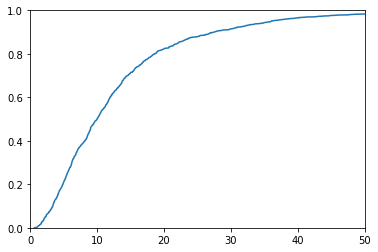

regression: 
rms_error: 17.811639847136465
mean_error: 13.693871506231945
generating cdf:


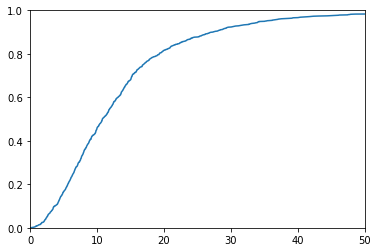

hierachical classification: 
rms_error: 18.77541585574408
mean_error: 13.713323775688519
generating cdf:


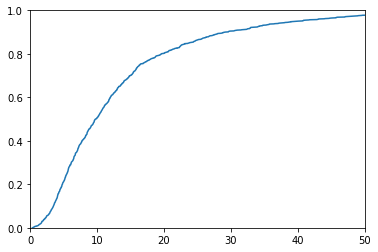

In [24]:
import math

test_df = pd.read_csv(path_validation,header = 0)
test_AP_strengths =test_df.loc[:,'WAP001':'WAP520']
test_AP_features = (np.asarray(test_AP_strengths))/200 + 0.5
test_df_LL = test_df.loc[:,'LONGITUDE':'LATITUDE']
test_labels = np.asarray(test_df_LL)
test_labels,ranges,test_bias =  normalization(test_labels)
preds = cross_model.predict(test_AP_features)
code = preds[:,:sum(digit)]
preds_y_point = []
for pred in code:
    preds_y_point.append(code_to_point(pred,digit))
mlp_reg = preds[:,sum(digit):]
pred_pos = 1/2*(1*mlp_reg + 1*preds_y_point)
print('fusion:')
error_analysis(pred_pos*ranges,test_labels*ranges)
print('regression: ')
error_analysis(mlp_reg*ranges,test_labels*ranges)
print('hierachical classification: ')
error_analysis(preds_y_point*ranges,test_labels*ranges)

In [11]:
#hirarchical_model.compile(optimizer=sgd(learning_rate=0.01), loss=[hirarchical_structure_loss],metrics=['binary_accuracy'])
#hirarchical_model.fit(train_X, train_code_y, nb_epoch=200, batch_size=batch_size)
def save_to_log(file_name,preds_pos):
    write_file = open(file_name,'w')
    for pos in preds_pos:
        line = str(pos[0])+','+str(pos[1])+'\n'
        write_file.write(line)
    return 
def load_log(file_name):
    read_file = open(file_name,'r')
    lines = read_file.readlines()
    pred_pos = []
    for line in lines:
        pos = line.split(',')
        x = float(pos[0])
        y = float(pos[1])
        pred_pos.append([x,y])
    return pred_pos

def rms(list):
    sum = 0
    for term in list:
        sum+= term*term
    rms = math.sqrt(sum / len(list))
    return rms

def cdf(error):
    count = len(error)
    cdf_y = [i/count for i in range(count)]
    error_sorted = sorted(error)
    plt.xlim(0,50)
    plt.ylim(0,1)
    plt.plot(error_sorted, cdf_y)
    plt.show()
    return cdf_y,error_sorted

def error_analysis(pred_y,true_y):
    error =np.sqrt((pred_y[:,0]-true_y[:,0])**2+(pred_y[:,1]-true_y[:,1])**2)

    rms_error = rms(error)
    print('rms_error:', rms_error)
    mean_error = sum(error)/len(error)
    print('mean_error:', mean_error)
    print("generating cdf:")
    cdf_y,error_sorted = cdf(error)
    return 
preds = hirarchical_model.predict(test_AP_features)
preds_y_point = [] 
for pred in preds:
    preds_y_point.append(code_to_point(pred,digit))
preds_result = preds_y_point*ranges+train_bias
save_to_log('hierachical_result.csv', preds_result)
log_load = load_log('hierachical_result.csv')
true_result = test_labels
error_analysis(preds_result,true_result)
shift = preds_result - true_result
shift_x = shift[:,0]
shift_y = shift[:,1]
#plt.scatter(shift_x, shift_y)
plt.scatter(preds_result[:,0],preds_result[:,1],color = 'b',s=5)
plt.scatter(true_result[:,0],true_result[:,1],color = 'r',s=5)
plt.show()
#print(preds_result[0])
#print(log_load[0])
#print(test_y_return[0])
result = []
for i in range(len(preds_result)):
    y = preds_result[i]
    y_hat = test_y_return[i]
    error = mean_squared_error(y,y_hat)
        #print(y,y_hat,error)
    plt.scatter(y[0],y[1],color='y',linewidth=2)
    if error < 30:
        #print(erlor='b')
        result.append(error)
    #plt.scatter(y_hat[0],y_hat[1],color='r')
    #plt.plot([y[0],y_hat[0]],[y[1],y_hat[1]])
#print(preds[1:10],test_labels[1:10])
#result = mean_squared_error_index(test_y,preds).numpy()
#plt.show()
cdf_result = cdf(result)
plt.xlim(0,100)
plt.ylim(0,1)
plt.plot(cdf_result[0],cdf_result[1])
#plt.savefig("25%fp,hierarchical,beta =" + str(i*0.01)+'.png')
plt.show()
    #errors.append(sum(result)/len(result))
print(sum(result)/len(result))


NameError: name 'hirarchical_model' is not defined

In [ ]:
nb_epochs = 20
batch_size = 10
input_size = 520
num_classes = 13

In [ ]:
def save_to_log(file_name,preds_pos,model_name):
    write_file = open(file_name)
    for pos in pred_pos:
        line = str(pos[0])+','str(pos[1]+'\n')
        write_file.write(line)
    

In [ ]:
from keras import backend as K
def mean_squared_error_index(y_true, y_pred):
    return K.mean(K.square(y_pred*ranges/100 - y_true*ranges/100), axis=-1)
def encoder():
    model = Sequential()
    model.add(Dense(512, input_dim=input_size, activation='tanh', bias=True))
    model.add(Dense(512, activation='tanh', bias=True))
    model.add(Dense(256, activation='tanh', bias=True))
    return model
def decoder(e):   
    e.add(Dense(256, input_dim=64, activation='tanh', bias=True))
    e.add(Dense(256, activation='tanh', bias=True))
    e.add(Dense(input_size, activation='tanh', bias=True))
    e.compile(optimizer='adam', loss='mse')
    return e

def encoder_mlp(d):
    num_to_remove = 3
    for i in range(num_to_remove):
        d.pop()
    d.add(Dense(256, input_dim=64, activation='relu', bias=True))
    d.add(Dense(32, activation='relu', bias=True))
    d.add(Dense(2, activation='sigmoid', bias=True))
    d.compile(optimizer='sgd', loss=[mean_squared_error_index],metrics=[mean_squared_error_index])
    return d

encoder = encoder()
decoder = decoder(encoder)
decoder.fit(train_X, train_X, nb_epoch=1, batch_size=batch_size)

def regression():
    model = Sequential()
    model.add(Dense(512, input_dim=input_size, activation='relu', bias=True))
    model.add(Dense(512, activation='relu', bias=True))
    model.add(Dense(128, activation='relu', bias=True))
    model.add(Dense(128, activation='relu', bias=True))
    model.add(Dense(32, activation='relu', bias=True))
    model.add(Dense(2, activation='sigmoid', bias=True))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=[mean_squared_error_index],metrics=[mean_squared_error_index])
    return model

In [ ]:
encoded_mlp = encoder_mlp(decoder)
encoded_mlp.fit(train_X, train_y,nb_epoch=500, batch_size=batch_size)

In [ ]:
model = mlp_regression()

In [ ]:
model.compile(optimizer=sgd(learning_rate=0.005), loss=[mean_squared_error_index],metrics=[mean_squared_error_index])
model.fit(train_X, train_y, nb_epoch=500, batch_size=batch_size)
loss,accuracy = model.evaluate(test_AP_features, test_labels)
print(loss,accuracy)

In [ ]:
##### import math
def cdf(data):
    hist, bin_edges = np.histogram(data,bins=100)
    cdf = np.cumsum(hist/sum(hist))
    return bin_edges[1:],cdf
def rms(list):
    sum = 0
    for term in list:
        sum+= term*term
    rms = math.sqrt(sum / len(list))
    return rms
preds = encoded_mlp.predict(test_AP_features)
#print(preds[1:10],test_labels[1:10])
test_pos = test_labels
preds_pos =  preds*test_ranges+train_bias
error = []
bias_pos = test_pos - preds_pos
test_x = test_pos[:,0]
test_y = test_pos[:,1]
preds_x = preds_pos[:,0]
preds_y = preds_pos[:,1]
plt.scatter(test_x, test_y, color='b')
plt.scatter(preds_x, preds_y, color='r')
plt.show()
for bia_pos in bias_pos:
    dis = math.sqrt(bia_pos[0]*bia_pos[0]+bia_pos[1]*bia_pos[1])
    if dis < 30:
        error.append(dis)
    
    
    
#result = np.sqrt(result*10000)
#cdf_result = cdf(result)
#import matplotlib.pyplot as plt
#plt.plot(cdf_result[0],cdf_result[1])
#plt.show()
print("rms error: ",sum(error)/len(error))

In [ ]:
### Final data-type#####
### A List indicating the floor_ID and building_ID
### A list of dictionaries: database = {'ID':ID,'FPs':FP,'locs':locs,'ts':ts}
### FP,locs,ts should be sorted as timestamp

In [ ]:
import pandas as pd
def formatted_fp(df):
    df = df.sort_values(by=['TIMESTAMP'])
    AP_strengths =df.loc[:,'WAP001':'WAP520']
    AP_features = (np.asarray(AP_strengths))/200 + 0.5
    building_ids_str = df["BUILDINGID"].map(str) #convert all the building ids to strings
    building_floors_str = df["FLOOR"].map(str) #convert all the building floors to strings
    time_stamp = df["TIMESTAMP"]
    res = building_ids_str + building_floors_str #element wise concatenation of BUILDINGID+FLOOR
    train_labels = np.asarray(building_ids_str + building_floors_str)    
    #convert labels to categorical variables, dummy_labels has type 'pandas.core.frame.DataFrame'
    dummy_labels = pd.get_dummies(train_labels)
    print(df.head(10))
    print(time_stamp.head(10))
    print(dummy_labels.head(10))
formatted_fp(train_df)